In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_2d, plot_2d_distribution, kl_estimate_with_mc, compute_variational_posterior
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

# Problem 1

The KL between q and p is 16.115 nats.


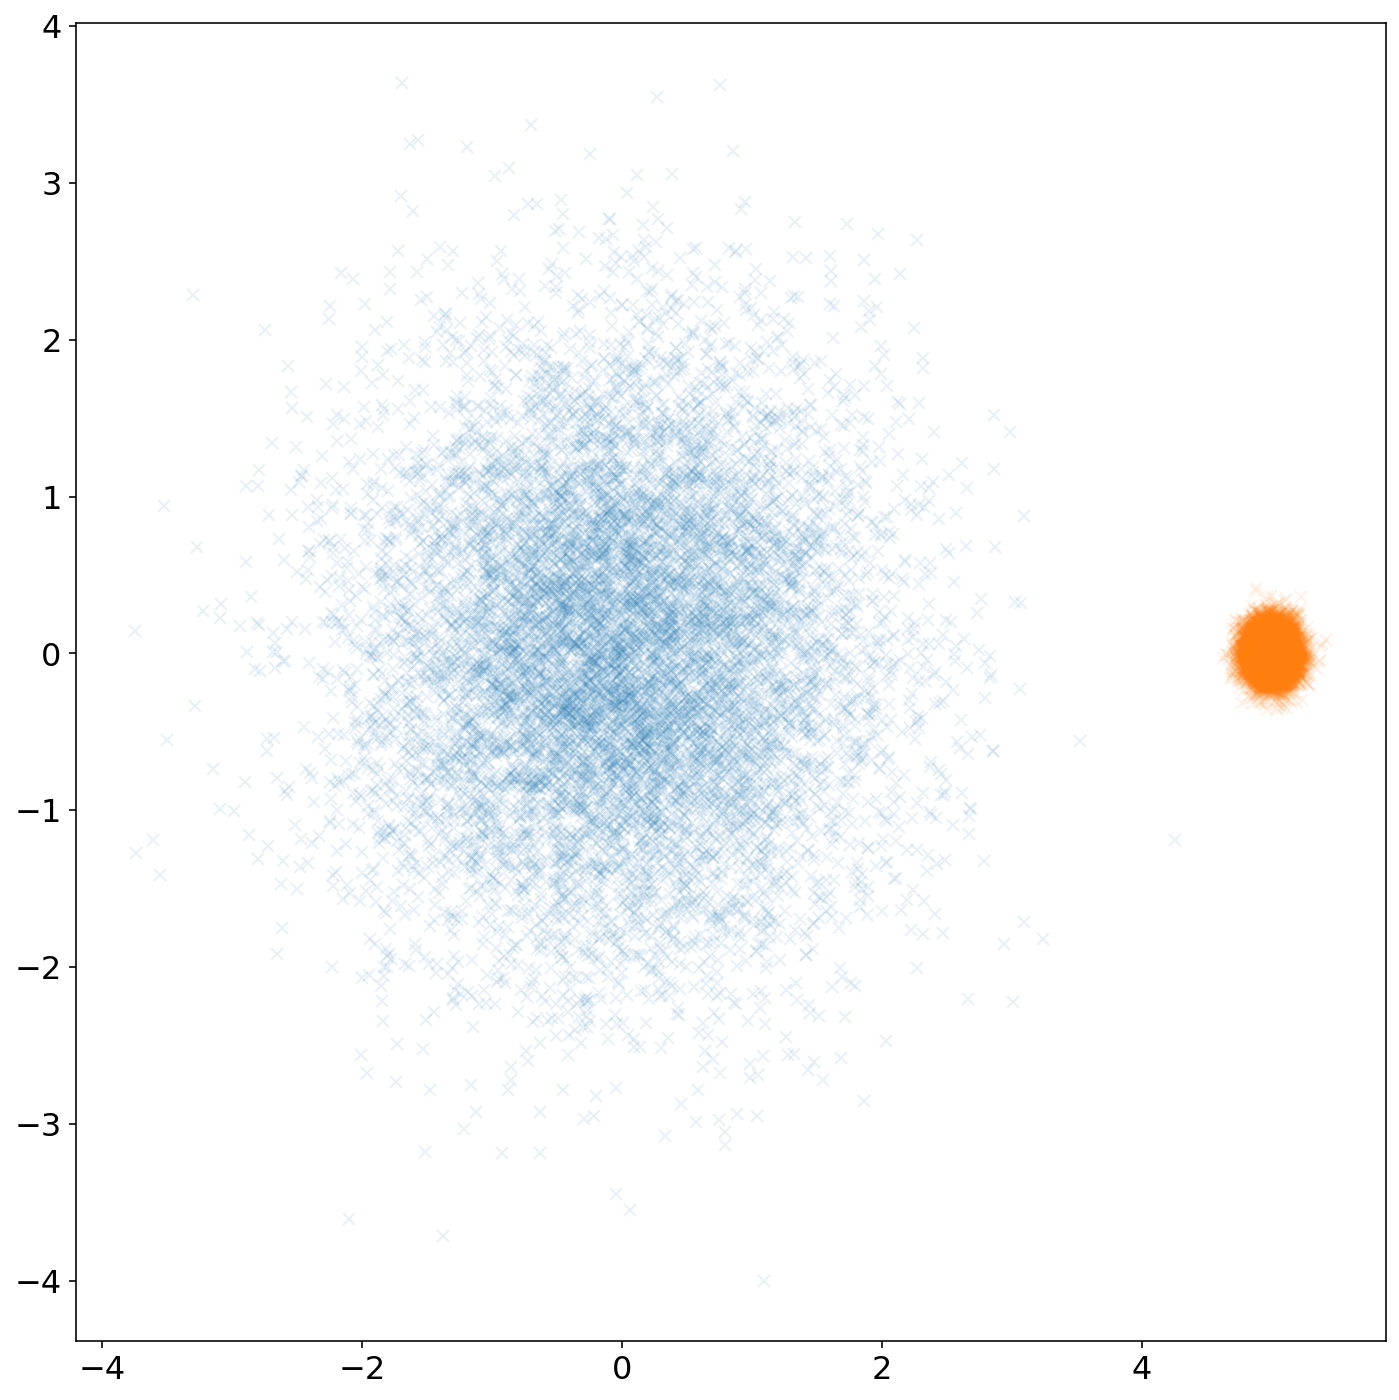

In [8]:
torch.manual_seed(100)

q_loc = [5., 0.]
q_covar = [[1, 0.], [0., 1]]

p_loc = [0., 0.]
p_var = 1.

q = dist.MultivariateNormal(loc=torch.tensor(q_loc), covariance_matrix = 0.01* torch.tensor(q_covar))
p = dist.MultivariateNormal(loc=torch.tensor(p_loc), covariance_matrix = p_var * torch.eye(2))

z_sample = q.mean

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================
p_samples = p.sample((10000,))
q_samples = q.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=0.1)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=0.1)

f.tight_layout()


In [9]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [10]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 3
initial_seed = 0
beamwidth = 1
epsilon = 0.
alpha = 1./p_var
dummy_encoder = Encoder(q,
                         initial_seed,
                         coding_sampler,
                         selection_sampler,
                         auxiliary_posterior,
                         omega,
                        n_samples_from_target=1,
                         beamwidth=beamwidth,
                         epsilon=epsilon,
                         prior_var=1./alpha)

n_trajectories = 5000
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, total_kl, n_trajectories, prior_var, lr=1e-3)
aux_vars = emp_opt.run_optimiser(epochs=5000)

The mean loss is 3.01719. The mean KL is: 2.97589: 100%|██████████| 5000/5000 [02:24<00:00, 34.71it/s] 


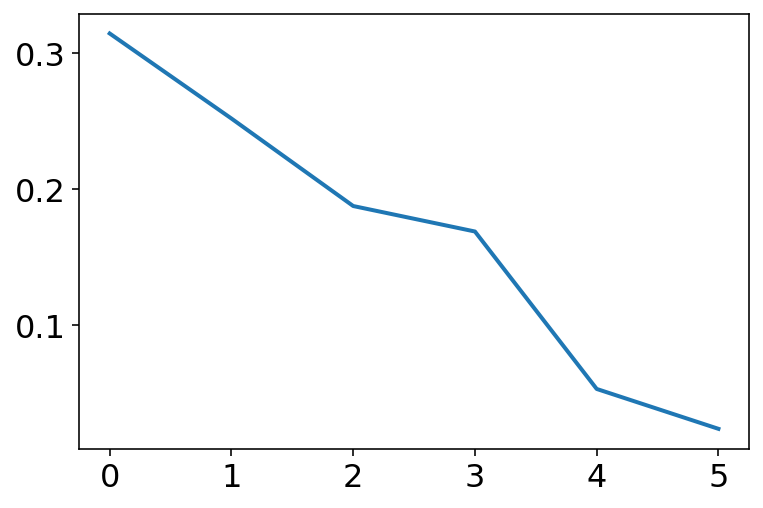

In [11]:
plt.plot(aux_vars)

In [12]:
aux_vars

tensor([0.3145, 0.2520, 0.1876, 0.1689, 0.0532, 0.0238])

In [55]:
initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 1000
opt_lqs = []
opt_zs = []
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=50,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha,
                 total_kl=total_kl)

    enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx =  enc.run_encoder()
    opt_zs.append(enc.selected_samples[0])
    opt_lqs.append(q.log_prob(z[0]).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
opt_traj = torch.empty([0])
for traj in opt_zs:
    opt_traj = torch.cat([opt_traj, traj[None]], dim=0)

In [57]:
torch.tensor(opt_lqs).mean()

tensor(-44.4037)

In [58]:
torch.mean(torch.topk(torch.tensor(opt_lqs), k=num_compressed_samples//2)[0])

tensor(-10.8237)

In [59]:
torch.topk(torch.tensor(opt_lqs), k=50)[1][25]

tensor(597)

In [85]:
emp_traj_optimised = opt_traj.mean(0)

In [61]:
un_opt_lqs = []
un_opt_zs = []
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=50,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha,
                 total_kl=total_kl)

    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx =  enc.run_encoder()
    un_opt_zs.append(enc.selected_samples[0])
    un_opt_lqs.append(q.log_prob(z[0]).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
un_opt_traj = torch.empty([0])
for traj in un_opt_zs:
    un_opt_traj = torch.cat([un_opt_traj, traj[None]], dim=0)

In [73]:
un_opt_traj.mean(0).sum(0)

tensor([ 4.4432, -0.0145])

In [74]:
opt_traj.mean(0).sum(0)

tensor([ 4.2304, -0.0152])

In [75]:
torch.tensor(un_opt_lqs).mean()

tensor(-27.2761)

In [66]:
torch.mean(torch.topk(torch.tensor(un_opt_lqs), k=num_compressed_samples//2)[0])

tensor(-5.0124)

In [67]:
torch.topk(torch.tensor(un_opt_lqs), k=50)[1][25]

tensor(529)

In [83]:
emp_traj_uniform = un_opt_traj.mean(0)

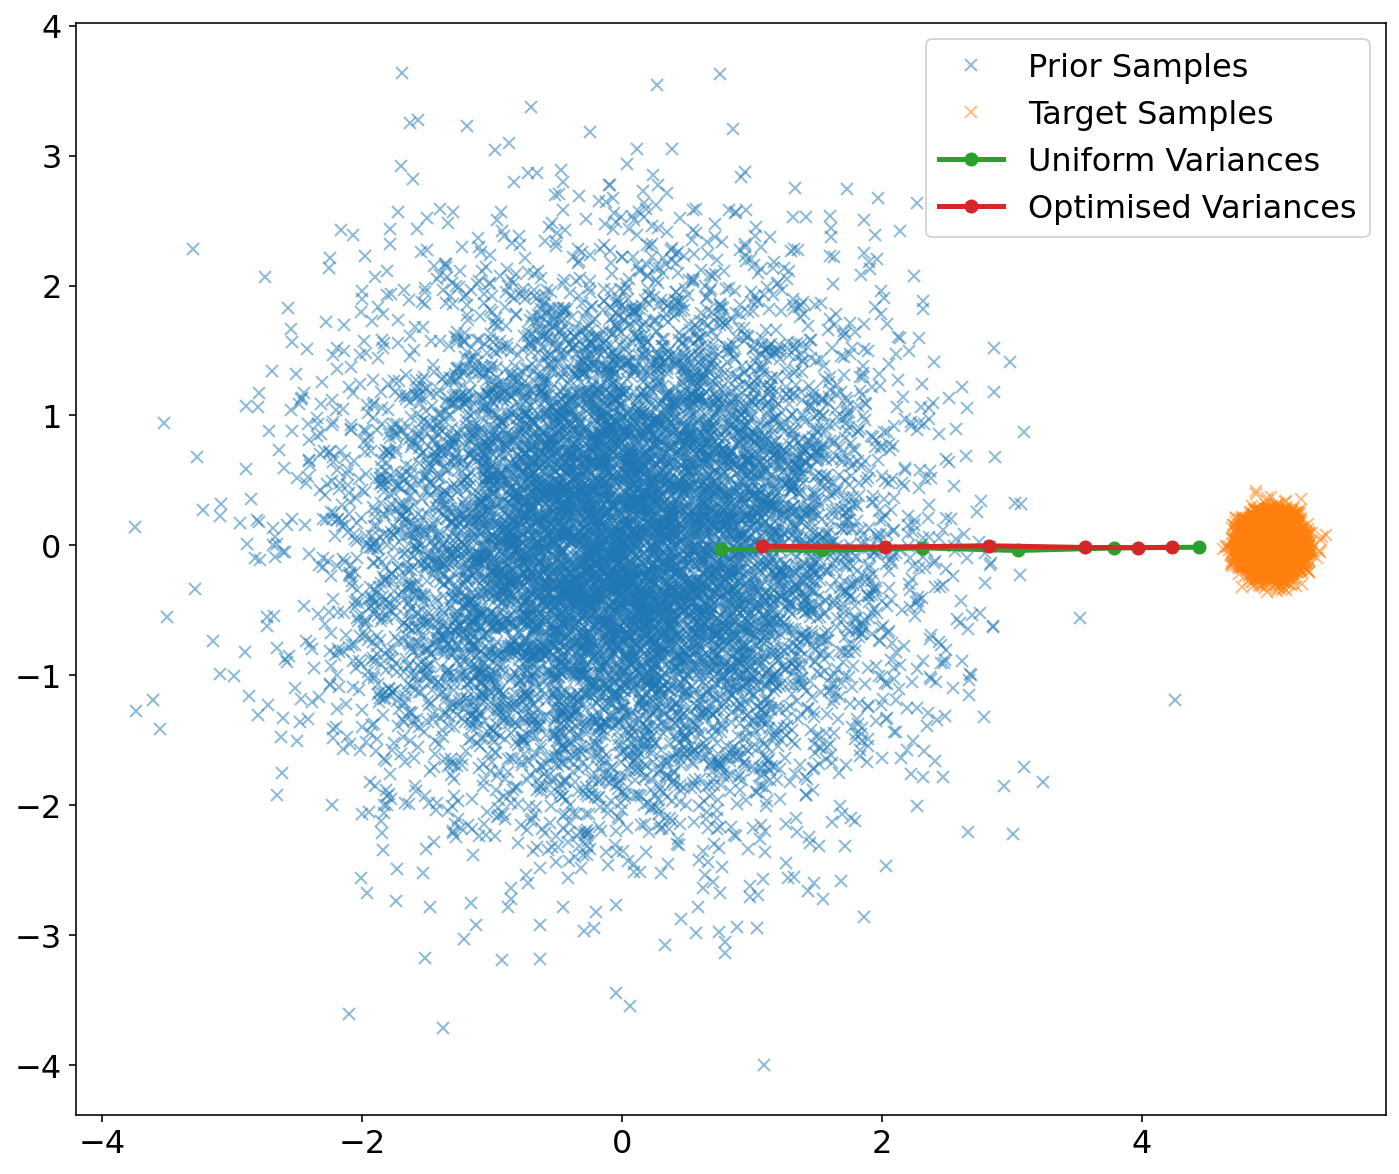

In [88]:
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=.5)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=.5)
ax.set_aspect('equal', adjustable='box')
plot_running_sum_2d(emp_traj_uniform, plot_index_labels=False)
plot_running_sum_2d(emp_traj_optimised, plot_index_labels=False)
ax.legend(['Prior Samples', 'Target Samples', 'Uniform Variances','Optimised Variances'], fontsize=16)
# ax.set_xlim(left=-0.2, right=0.2)
# ax.set_ylim(bottom=-2**0.5 -0.1, top=-2**0.5 + 0.2)
#ax.margins(x=-0.4, y=-0.4) 
ax.set_xlabel(r"$\mathbf{z}_1$")
ax.set_ylabel(r"$\mathbf{z}_2$")
f.tight_layout()
f.savefig("Figures/Thesis/optimised_variances_far_target.pdf", bbox_inches='tight')